### Project: Customer_segmentation
Customer segmentation with Machine Learning Kmeans model.

Dataset: fictitious

In [1]:

!pip install -q threadpoolctl==3.1.0

In [2]:
### Imports

import threadpoolctl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')



In [3]:
data = pd.read_csv('dataset.csv')

EDA

In [4]:
data.head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
0,48,529.152948,13,0.524262,2,1
1,37,684.502168,13,0.628494,2,0
2,31,797.016155,17,0.706550,1,0
3,30,542.025205,12,0.517458,3,0
4,44,655.498896,15,0.774564,3,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Idade                99 non-null     int64  
 1   Gasto_Mensal         99 non-null     float64
 2   Tempo_de_Assinatura  99 non-null     int64  
 3   Taxa_de_Uso          99 non-null     float64
 4   Suporte_Tickets      99 non-null     int64  
 5   Cancelou             99 non-null     int64  
dtypes: float64(2), int64(4)
memory usage: 4.8 KB


In [8]:
data.shape

(99, 6)

In [10]:
## data is null ?
data.isnull().sum().sort_values(ascending=False)

Idade                  0
Gasto_Mensal           0
Tempo_de_Assinatura    0
Taxa_de_Uso            0
Suporte_Tickets        0
Cancelou               0
dtype: int64

In [64]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Idade                   20.500000
Gasto_Mensal           480.817001
Tempo_de_Assinatura     11.000000
Taxa_de_Uso              0.434911
Suporte_Tickets          1.000000
Cancelou                 1.000000
dtype: float64


In [68]:
### Outliers

outliers = ((data < (Q1 - 2.5 * IQR)) | (data > (Q3 + 2.5 * IQR))).any(axis=1)

In [70]:
df_outliers = data[outliers]

In [71]:
df_outliers

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
12,46,743.034018,16,0.697133,5,0
53,48,550.847824,12,0.619646,7,1
54,43,667.040379,13,0.630056,5,0
63,34,694.989179,17,0.536049,7,1
95,53,999.943535,23,0.865750,5,1
96,48,999.327367,21,0.926680,5,1


<Axes: xlabel='Suporte_Tickets'>

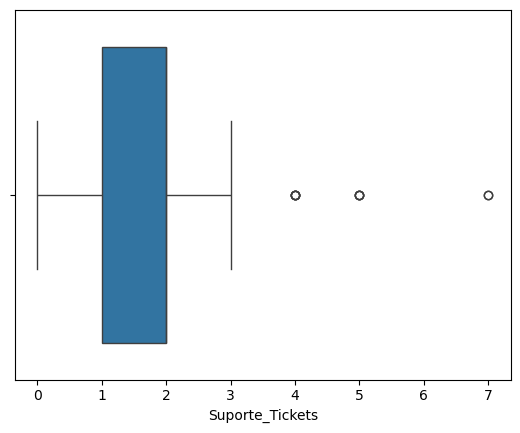

In [34]:
sns.boxplot(x=data['Suporte_Tickets'])

<Axes: xlabel='Cancelou'>

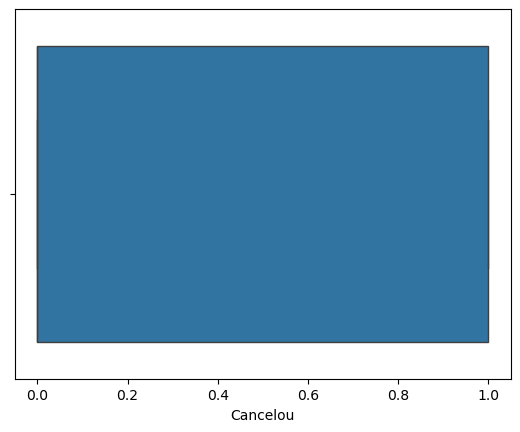

In [35]:
sns.boxplot(x=data['Cancelou'])

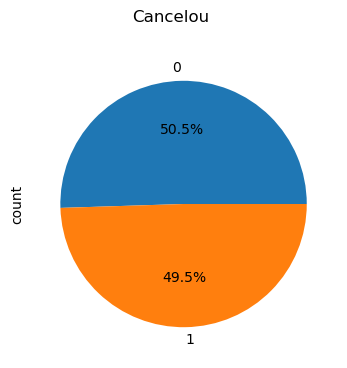

In [44]:
fig, axes = plt.subplots(1, 1, figsize = (10, 4))
fig.suptitle('Cancelou')
data['Cancelou'].value_counts().plot(kind = 'pie', autopct = '%1.1f%%');

In [46]:
freq_cancelou = data['Cancelou'].value_counts()
freq_cancelou

Cancelou
0    50
1    49
Name: count, dtype: int64

In [48]:
perc_freq_cancelou = data['Cancelou'].value_counts(normalize=True)*100
perc_freq_cancelou

Cancelou
0    50.505051
1    49.494949
Name: proportion, dtype: float64

In [49]:
dist_freq_cancelou = pd.DataFrame({'Freq': freq_cancelou, 'Percent %': perc_freq_cancelou})
dist_freq_cancelou

,Freq,Percent %
Cancelou,,
0,50,50.505051
1,49,49.494949


In [50]:
data.describe()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,39.888889,639.071009,13.646465,0.604374,1.747475,0.494949
std,13.089869,270.618268,6.599804,0.263824,1.486974,0.502519
min,18.000000,106.254563,1.000000,0.110168,0.000000,0.000000
25%,29.000000,394.918421,8.000000,0.414928,1.000000,0.000000
50%,38.000000,709.104722,15.000000,0.623406,2.000000,0.000000
75%,49.500000,875.735422,19.000000,0.849839,2.000000,1.000000
max,64.000000,999.943535,23.000000,0.996007,7.000000,1.000000


In [72]:
### Correlation

corr_mtx = data.corr()
corr_mtx

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
Idade,1.000000,0.856041,0.814066,0.846363,0.431047,0.624298
Gasto_Mensal,0.856041,1.000000,0.914275,0.912730,0.378802,0.651229
Tempo_de_Assinatura,0.814066,0.914275,1.000000,0.891799,0.427516,0.687107
Taxa_de_Uso,0.846363,0.912730,0.891799,1.000000,0.380526,0.643879
Suporte_Tickets,0.431047,0.378802,0.427516,0.380526,1.000000,0.278220
Cancelou,0.624298,0.651229,0.687107,0.643879,0.278220,1.000000


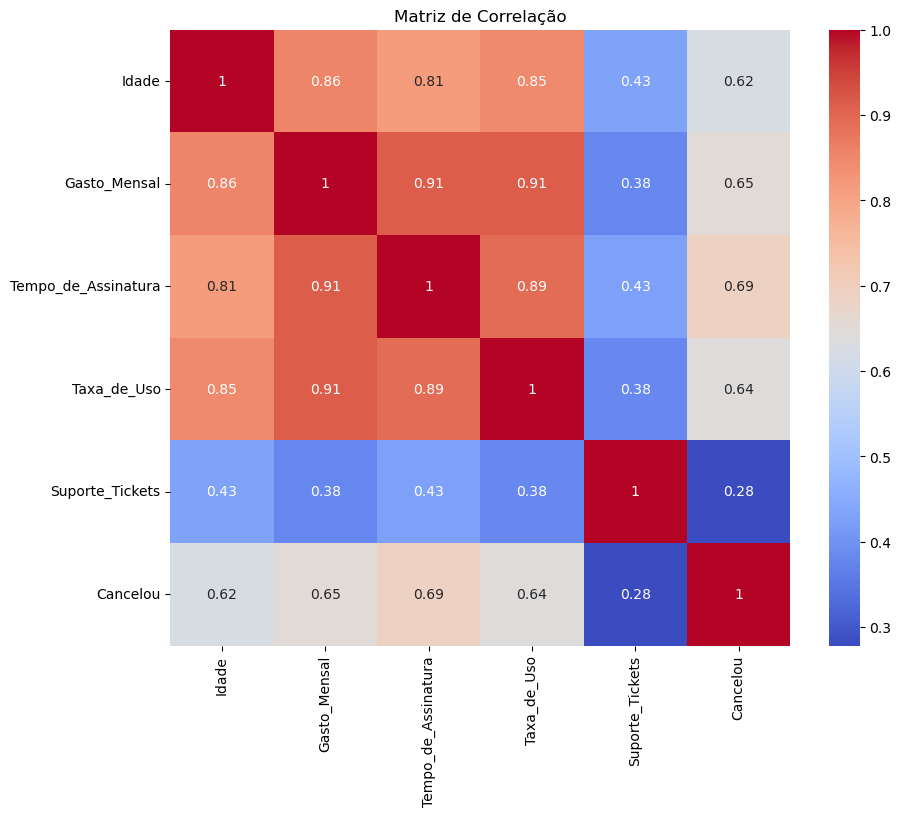

In [73]:
# Plot
plt.figure(figsize = (10,8))
sns.heatmap(corr_mtx, annot = True, cmap = 'coolwarm')
plt.title('Matriz de Correlação')
plt.show()

In [74]:
### Padronizador
scaler = StandardScaler()

In [75]:
df_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [77]:
df_scaled.head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
0,0.622801,-0.408241,-0.098451,-0.305201,0.170689,1.010153
1,-0.221820,0.168733,-0.098451,0.091893,0.170689,-0.989949
2,-0.682522,0.586616,0.510712,0.389261,-0.505240,-0.989949
3,-0.759306,-0.360433,-0.250741,-0.331122,0.846619,-0.989949
4,0.315666,0.061014,0.206131,0.648375,0.846619,-0.989949


In [78]:
data.head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
0,48,529.152948,13,0.524262,2,1
1,37,684.502168,13,0.628494,2,0
2,31,797.016155,17,0.706550,1,0
3,30,542.025205,12,0.517458,3,0
4,44,655.498896,15,0.774564,3,0


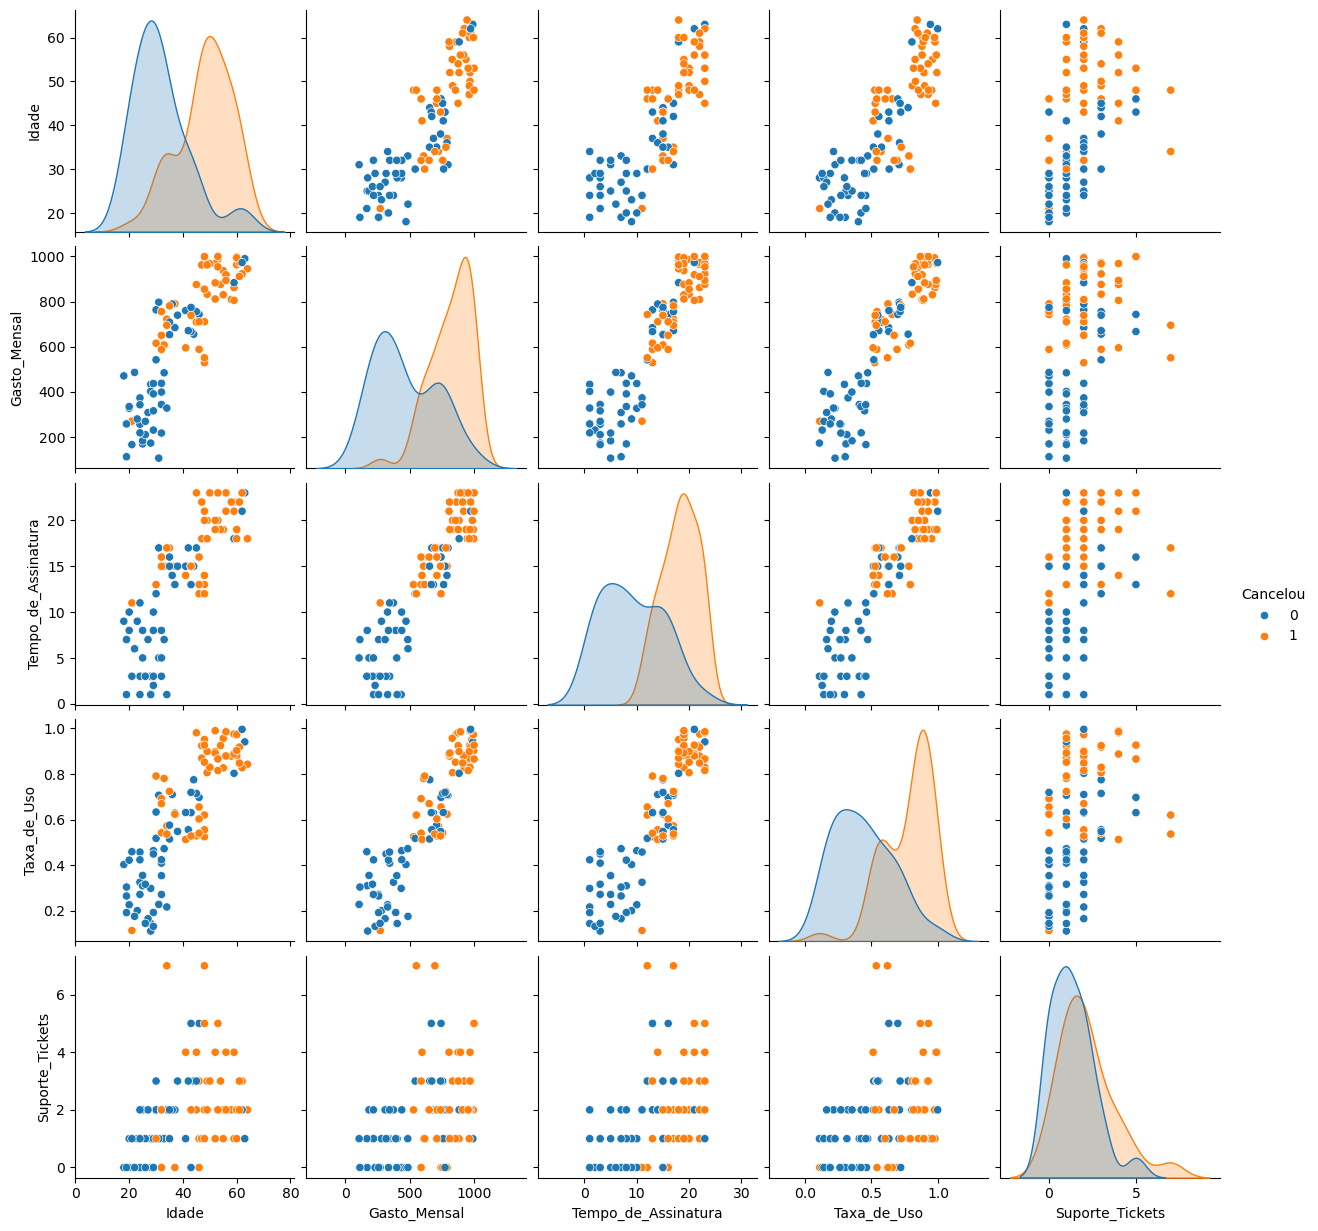

In [79]:
sns.pairplot(data, hue = 'Cancelou', diag_kind = 'kde')
plt.show()

#### K-values - Metod Cotovelo

In [80]:
sse = []

In [81]:
k_range = range(1, 11)

In [82]:
# Testando os valores
for k in k_range:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

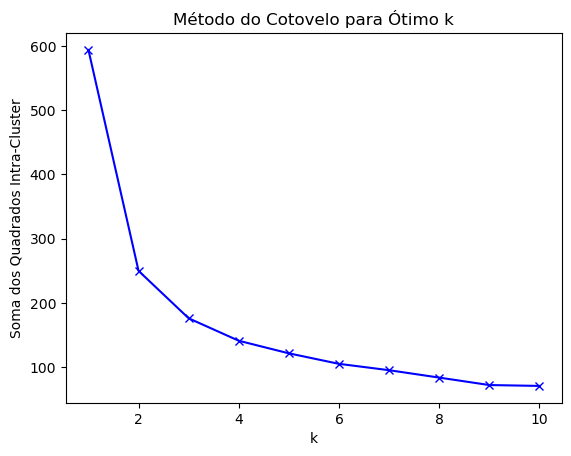

In [83]:
# Plot
plt.plot(k_range, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma dos Quadrados Intra-Cluster')
plt.title('Método do Cotovelo para Ótimo k')
plt.show()

#### K-values - Metod Silhoeta

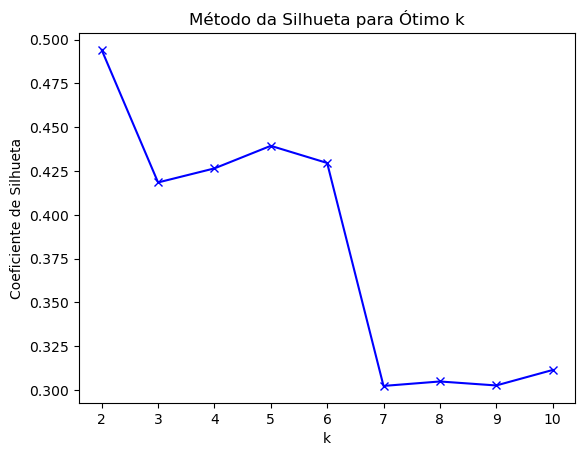

In [84]:
### Sil Score 
sil_score = []

# Loop pelo range de valores de k a serem testados
for k in k_range:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_scaled)
    
    # Silhouette score não é definido para k = 1, então filtramos
    if k != 1:
        sil_score.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot
plt.plot(k_range[1:], sil_score, 'bx-')
plt.xlabel('k')
plt.ylabel('Coeficiente de Silhueta')
plt.title('Método da Silhueta para Ótimo k')
plt.show()

#### Models

In [85]:
# V1 k= 4
model_v1 = KMeans(n_clusters=4, random_state=42)

In [86]:
data['cluster'] = model_v1.fit_predict(df_scaled)

In [87]:
data.sample(10)

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
63,34,694.989179,17,0.536049,7,1,3
3,30,542.025205,12,0.517458,3,0,3
47,36,789.085993,14,0.709854,2,0,3
10,32,588.077553,16,0.691481,0,1,2
75,59,883.648607,18,0.802909,2,0,1
29,29,230.616308,2,0.130792,0,0,0
96,48,999.327367,21,0.926680,5,1,1
36,20,334.700466,8,0.421469,0,0,0
55,35,780.846432,17,0.723213,1,1,2
19,28,402.144564,1,0.143157,1,0,0


In [88]:
data.shape

(99, 7)

In [89]:
data_cleaned = data

In [90]:
data_cleaned.shape

(99, 7)

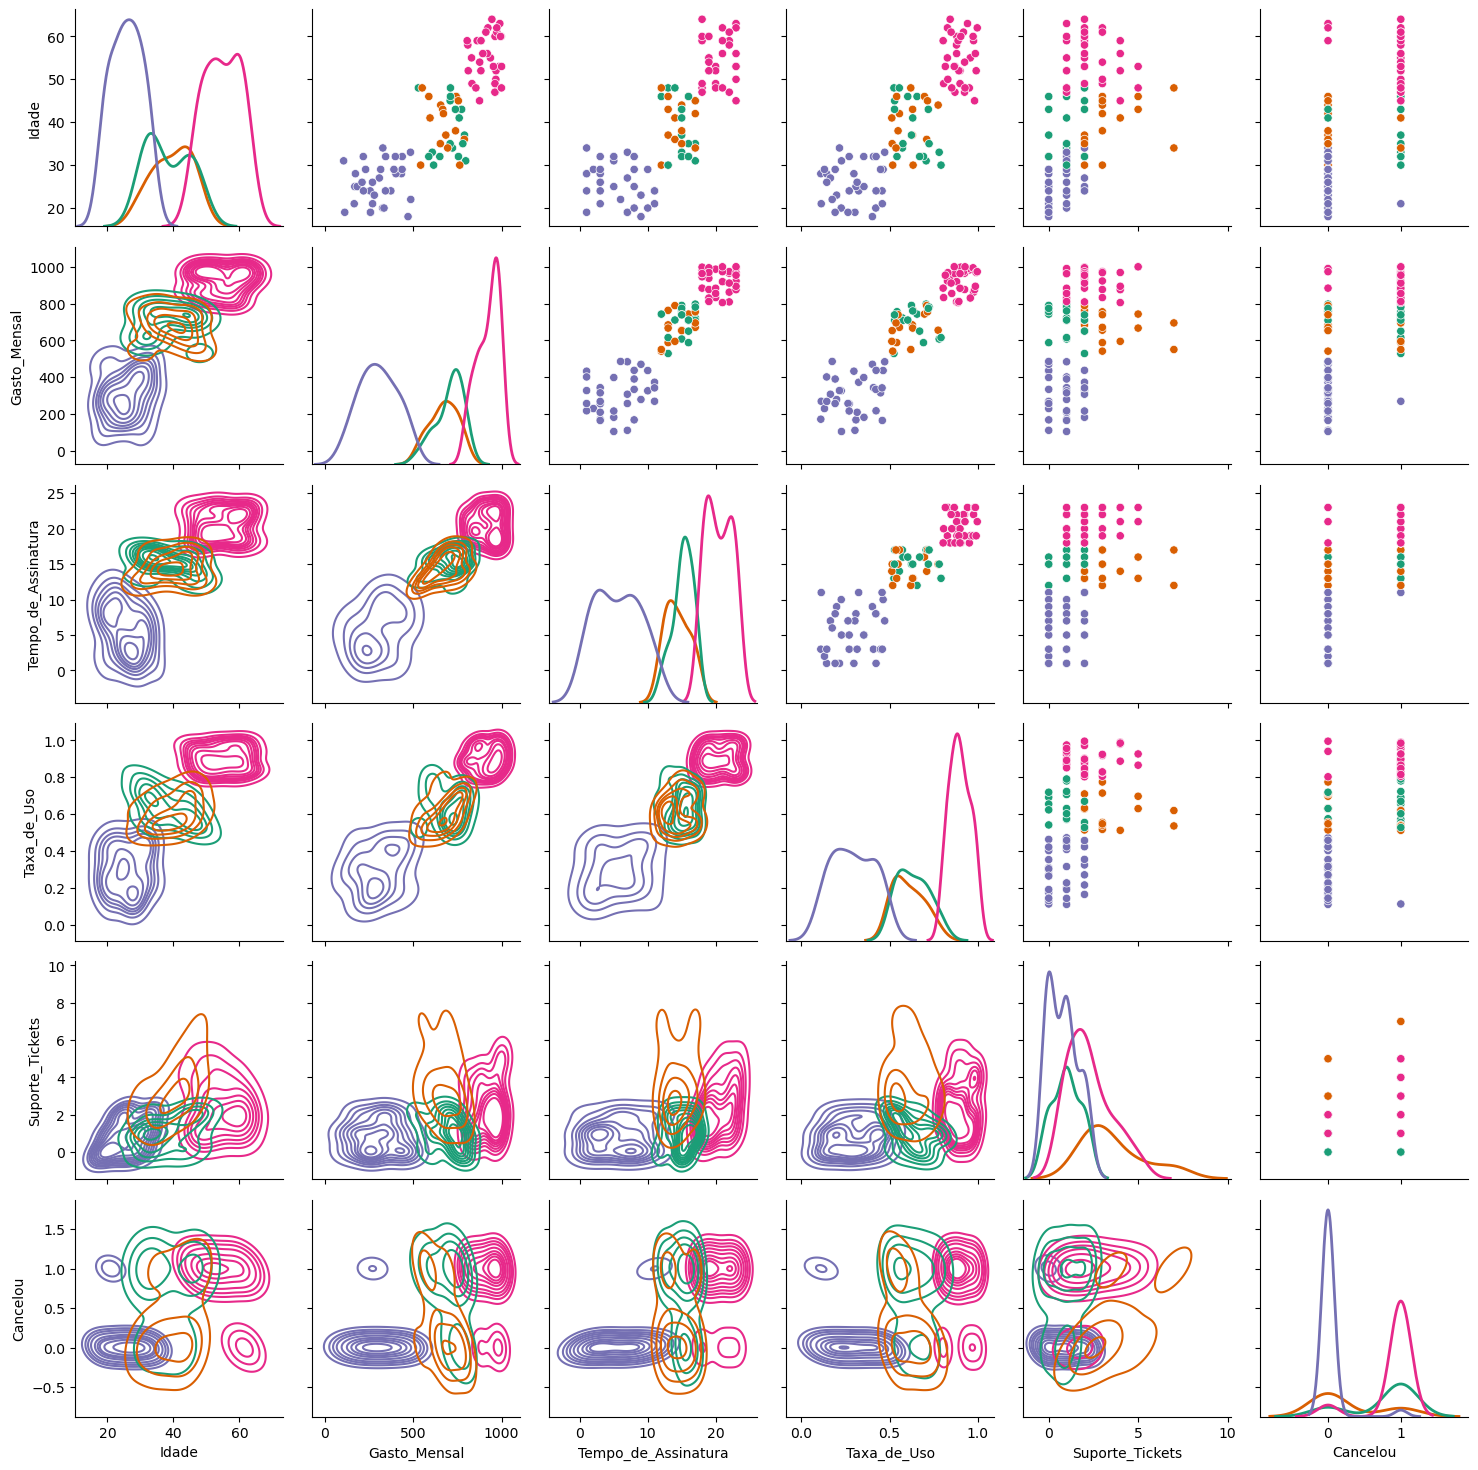

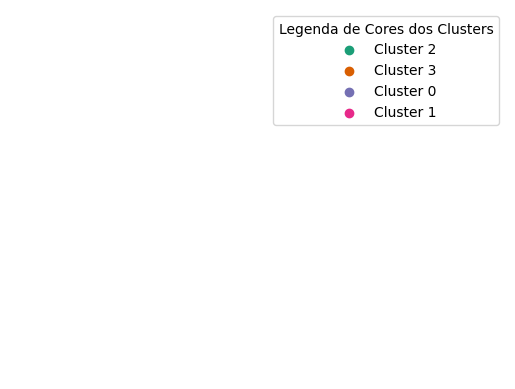

In [91]:
# Criando um mapa de cores baseado na paleta 'Dark2'
palette = sns.color_palette('Dark2', n_colors = len(data_cleaned['cluster'].unique()))
color_map = dict(zip(data_cleaned['cluster'].unique(), palette))

# Plotando o gráfico de grid com os clusters e mostrando o mapa de cores
g = sns.PairGrid(data_cleaned, hue = 'cluster', palette = color_map, diag_sharey = False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)
plt.show()

# Mostrando o mapa de cores
for cluster, color in color_map.items():
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')
plt.legend(title = 'Legenda de Cores dos Clusters')
plt.axis('off')
plt.show()

In [92]:
# V2 k= 3
model_v2 = KMeans(n_clusters=3, random_state=42)

In [93]:
data.drop('cluster', axis=1, inplace=True)

In [94]:
data.head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
0,48,529.152948,13,0.524262,2,1
1,37,684.502168,13,0.628494,2,0
2,31,797.016155,17,0.706550,1,0
3,30,542.025205,12,0.517458,3,0
4,44,655.498896,15,0.774564,3,0


In [95]:
data['cluster'] = model_v2.fit_predict(df_scaled)

In [96]:
data.sample(10)

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
17,24,256.424243,3,0.271016,0,0,0
16,25,169.345861,8,0.309093,0,0,0
25,23,279.901653,9,0.199717,1,0,0
15,28,433.277965,1,0.297518,0,0,0
88,50,967.665741,23,0.829415,3,1,1
36,20,334.700466,8,0.421469,0,0,0
38,24,342.813699,11,0.457024,2,0,0
48,32,755.902837,15,0.541506,0,1,2
39,26,210.399673,3,0.315737,1,0,0
9,33,607.847345,15,0.780384,1,1,2


In [97]:
data_cleaned = data[~outliers]

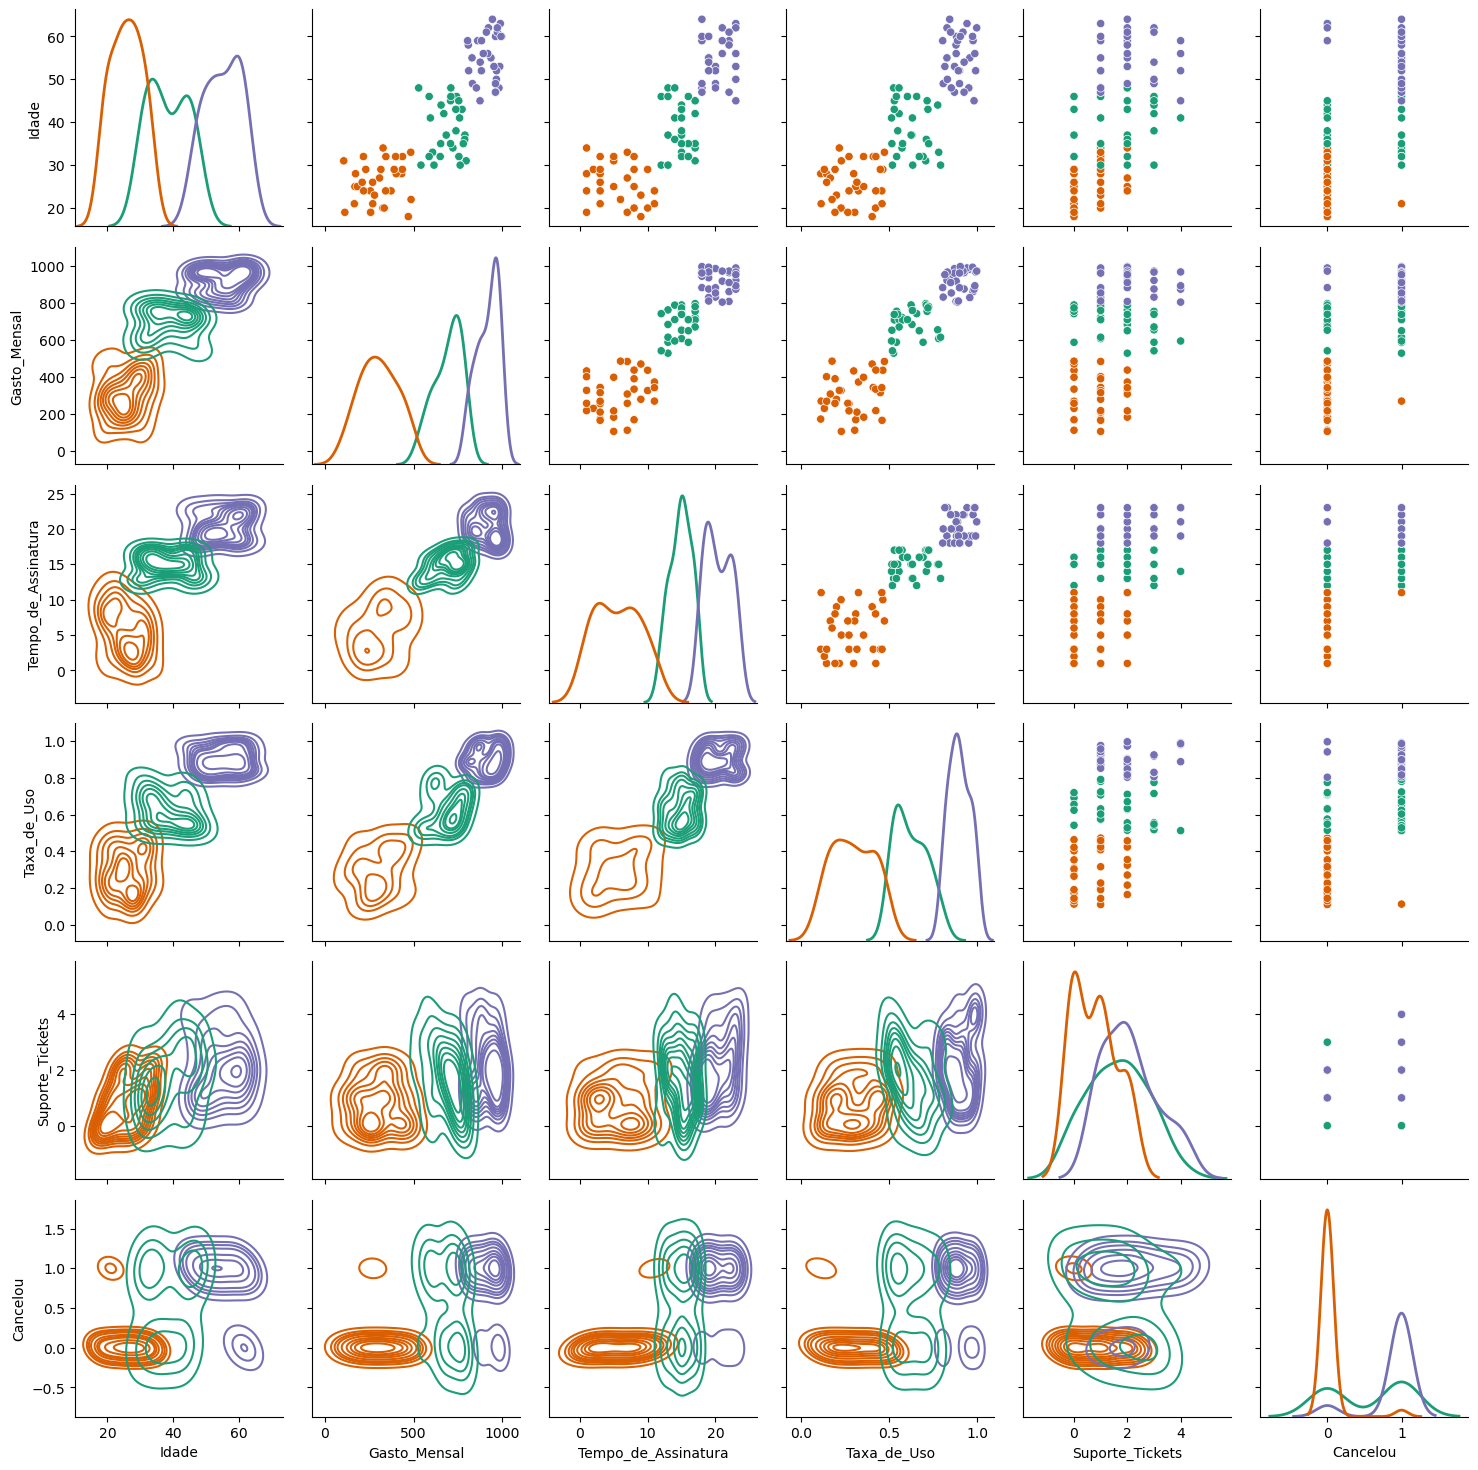

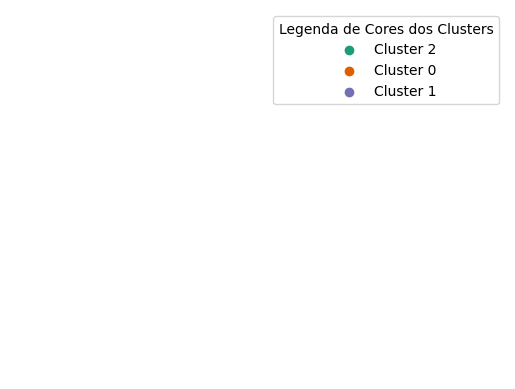

In [99]:
# Criando um mapa de cores baseado na paleta 'Dark2'
palette = sns.color_palette('Dark2', n_colors = len(data_cleaned['cluster'].unique()))
color_map = dict(zip(data_cleaned['cluster'].unique(), palette))

# Plotando o gráfico de grid com os clusters e mostrando o mapa de cores
g = sns.PairGrid(data_cleaned, hue = 'cluster', palette = color_map, diag_sharey = False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)
plt.show()

# Mostrando o mapa de cores
for cluster, color in color_map.items():
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')
plt.legend(title = 'Legenda de Cores dos Clusters')
plt.axis('off')
plt.show()

### Analys

In [100]:
## Clusters

data_cleaned.head(5)

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
0,48,529.152948,13,0.524262,2,1,2
1,37,684.502168,13,0.628494,2,0,2
2,31,797.016155,17,0.706550,1,0,2
3,30,542.025205,12,0.517458,3,0,2
4,44,655.498896,15,0.774564,3,0,2


In [101]:
data_cleaned.sample(5)

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
29,29,230.616308,2,0.130792,0,0,0
69,49,832.523388,20,0.805757,3,1,1
49,46,588.334668,13,0.539824,3,1,2
52,41,595.076602,14,0.512320,4,1,2
33,32,437.813539,8,0.423248,2,0,0


In [102]:
data_cleaned[data_cleaned.cluster == 0].head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
13,24,373.305408,11,0.324511,2,0,0
14,32,343.998663,3,0.408387,1,0,0
15,28,433.277965,1,0.297518,0,0,0
16,25,169.345861,8,0.309093,0,0,0
17,24,256.424243,3,0.271016,0,0,0


In [103]:
data_cleaned[data_cleaned.cluster == 0].mean()

Idade                   25.848485
Gasto_Mensal           302.863443
Tempo_de_Assinatura      5.606061
Taxa_de_Uso              0.293108
Suporte_Tickets          0.787879
Cancelou                 0.030303
cluster                  0.000000
dtype: float64

In [104]:
data_cleaned[data_cleaned.cluster == 1].head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
66,59,861.905523,22,0.975331,1,1,1
67,60,962.759004,19,0.880697,1,1,1
68,55,936.946235,19,0.826803,2,1,1
69,49,832.523388,20,0.805757,3,1,1
70,48,982.185437,18,0.951027,1,1,1


In [105]:
data_cleaned[data_cleaned.cluster == 1].mean()

Idade                   55.129032
Gasto_Mensal           919.013690
Tempo_de_Assinatura     20.387097
Taxa_de_Uso              0.897477
Suporte_Tickets          2.096774
Cancelou                 0.903226
cluster                  1.000000
dtype: float64

In [106]:
data_cleaned[data_cleaned.cluster == 2].head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,cluster
0,48,529.152948,13,0.524262,2,1,2
1,37,684.502168,13,0.628494,2,0,2
2,31,797.016155,17,0.706550,1,0,2
3,30,542.025205,12,0.517458,3,0,2
4,44,655.498896,15,0.774564,3,0,2


In [107]:
data_cleaned[data_cleaned.cluster == 2].mean()

Idade                   38.448276
Gasto_Mensal           694.101019
Tempo_de_Assinatura     14.896552
Taxa_de_Uso              0.622873
Suporte_Tickets          1.655172
Cancelou                 0.551724
cluster                  2.000000
dtype: float64

In [108]:
# Extrai os centróides
centroides = model_v1.cluster_centers_

In [110]:
print(centroides)

[[-1.07807472 -1.24869086 -1.22447918 -1.1858289  -0.64861907 -0.92934034]
 [ 1.14865372  1.05786786  1.04142262  1.11634458  0.35503359  0.82832509]
 [-0.11517561  0.24526441  0.23997331  0.1138236  -0.50524012  0.56568542]
 [-0.01706305  0.12549329  0.11475647  0.01627719  1.25217618 -0.45658895]]


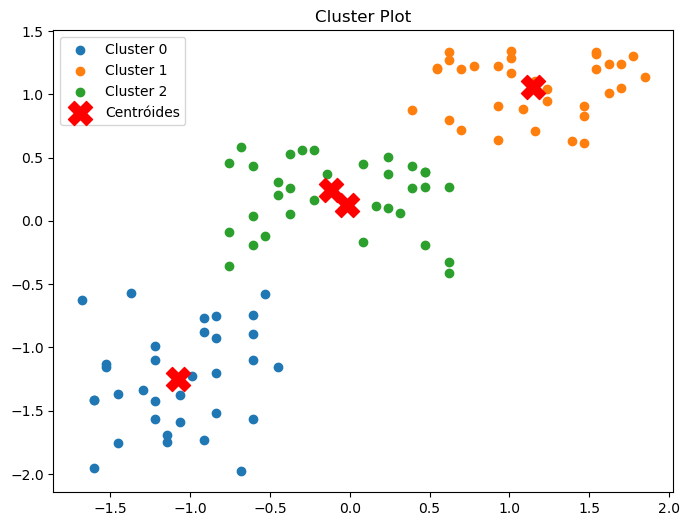

In [111]:
# Cria a figura
plt.figure(figsize = (8, 6))

# Loop pelos clusters
for cluster_num in range(3):
    mask = data['cluster'] == cluster_num
    plt.scatter(df_scaled[mask].iloc[:, 0], df_scaled[mask].iloc[:, 1], label = f'Cluster {cluster_num}')

# Plot
plt.scatter(model_v1.cluster_centers_[:, 0], 
            model_v1.cluster_centers_[:, 1], 
            s = 300, 
            c = 'red', 
            marker = 'X', 
            label = 'Centróides')
plt.legend()
plt.title("Cluster Plot")
plt.show()

In [112]:
data['cluster'].value_counts()

cluster
2    33
0    33
1    33
Name: count, dtype: int64

In [113]:
# Siluet
data.groupby('cluster').mean()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
cluster,,,,,,
0,25.848485,302.863443,5.606061,0.293108,0.787879,0.030303
1,54.848485,923.899857,20.484848,0.897401,2.272727,0.909091
2,38.969697,690.449726,14.848485,0.622612,2.181818,0.545455


In [114]:
score = silhouette_score(df_scaled, data['cluster'])
print(score)

0.41846445080765354


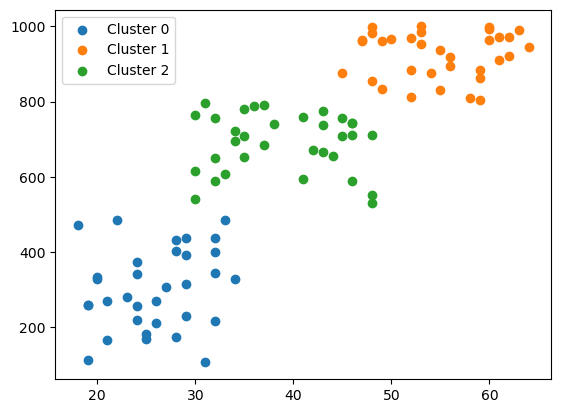

In [115]:
# Plot
plt.scatter(data[data['cluster'] == 0]['Idade'], data[data['cluster'] == 0]['Gasto_Mensal'], label='Cluster 0')
plt.scatter(data[data['cluster'] == 1]['Idade'], data[data['cluster'] == 1]['Gasto_Mensal'], label='Cluster 1')
plt.scatter(data[data['cluster'] == 2]['Idade'], data[data['cluster'] == 2]['Gasto_Mensal'], label='Cluster 2')
plt.legend()
plt.show()

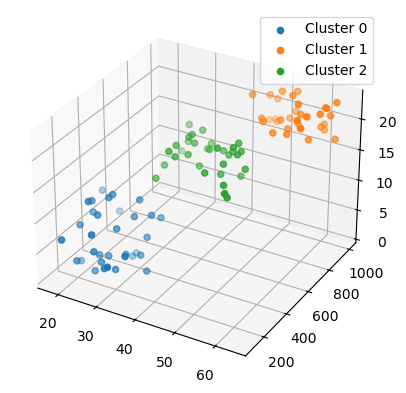

In [116]:
# Plot 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data[data['cluster'] == 0]['Idade'], data[data['cluster'] == 0]['Gasto_Mensal'], data[data['cluster'] == 0]['Tempo_de_Assinatura'], label='Cluster 0')
ax.scatter(data[data['cluster'] == 1]['Idade'], data[data['cluster'] == 1]['Gasto_Mensal'], data[data['cluster'] == 1]['Tempo_de_Assinatura'], label='Cluster 1')
ax.scatter(data[data['cluster'] == 2]['Idade'], data[data['cluster'] == 2]['Gasto_Mensal'], data[data['cluster'] == 2]['Tempo_de_Assinatura'], label='Cluster 2')

ax.legend()
plt.show()

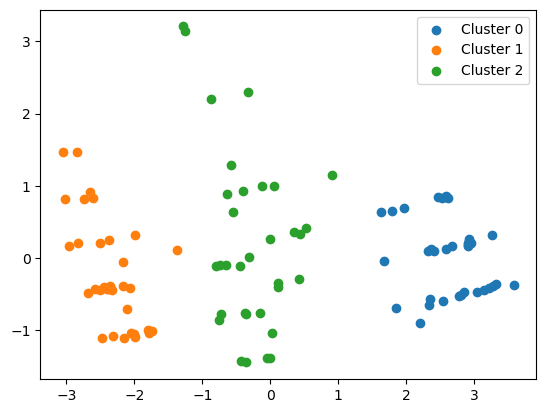

In [117]:
# Visualização com PCA
from sklearn.decomposition import PCA

# Cria o modelo PCA com 2 componentes principais
pca = PCA(n_components = 2)

# Treina o modelo usando dados padronizados
principalComponents = pca.fit_transform(df_scaled)

# Cria o dataframe com o resultado
df_principal = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])
df_principal['cluster'] = data['cluster']

# Cria o gráfico
plt.scatter(df_principal[df_principal['cluster'] == 0]['PC 1'], df_principal[df_principal['cluster'] == 0]['PC 2'], label='Cluster 0')
plt.scatter(df_principal[df_principal['cluster'] == 1]['PC 1'], df_principal[df_principal['cluster'] == 1]['PC 2'], label='Cluster 1')
plt.scatter(df_principal[df_principal['cluster'] == 2]['PC 1'], df_principal[df_principal['cluster'] == 2]['PC 2'], label='Cluster 2')
plt.legend()
plt.show()

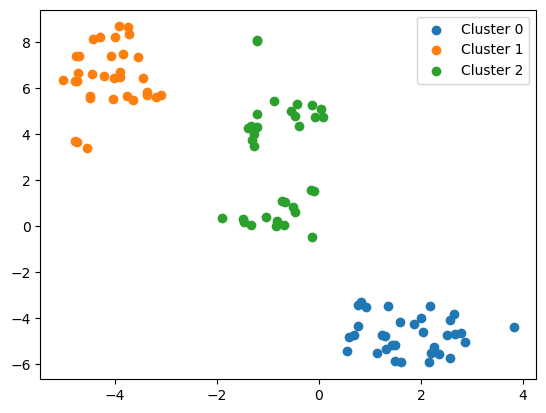

In [118]:
# Visualização com t-SNE (t-distributed Stochastic Neighbor Embedding) 
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
tsne_results = tsne.fit_transform(df_scaled)
df_tsne = pd.DataFrame(data = tsne_results, columns = ['tsne 1', 'tsne 2'])
df_tsne['cluster'] = data['cluster']

plt.scatter(df_tsne[df_tsne['cluster'] == 0]['tsne 1'], df_tsne[df_tsne['cluster'] == 0]['tsne 2'], label='Cluster 0')
plt.scatter(df_tsne[df_tsne['cluster'] == 1]['tsne 1'], df_tsne[df_tsne['cluster'] == 1]['tsne 2'], label='Cluster 1')
plt.scatter(df_tsne[df_tsne['cluster'] == 2]['tsne 1'], df_tsne[df_tsne['cluster'] == 2]['tsne 2'], label='Cluster 2')
plt.legend()
plt.show()

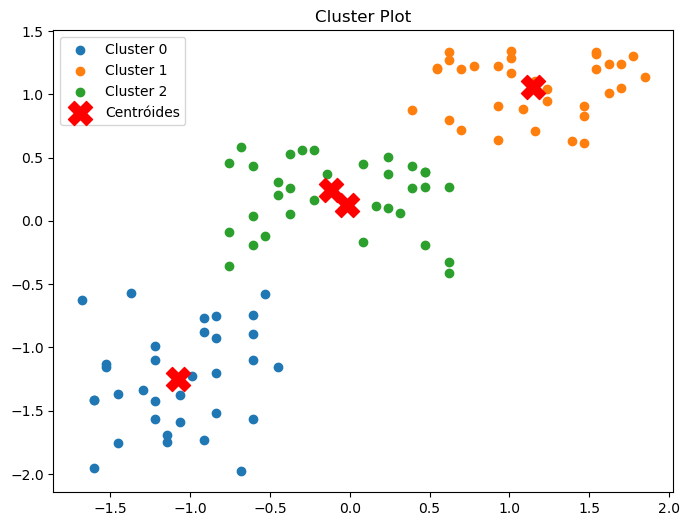

In [119]:
# Cria a figura
plt.figure(figsize = (8, 6))

# Loop pelos clusters
for cluster_num in range(3):
    mask = data['cluster'] == cluster_num
    plt.scatter(df_scaled[mask].iloc[:, 0], df_scaled[mask].iloc[:, 1], label = f'Cluster {cluster_num}')

# Plot
plt.scatter(model_v1.cluster_centers_[:, 0], 
            model_v1.cluster_centers_[:, 1], 
            s = 300, 
            c = 'red', 
            marker = 'X', 
            label = 'Centróides')
plt.legend()
plt.title("Cluster Plot")
plt.show()

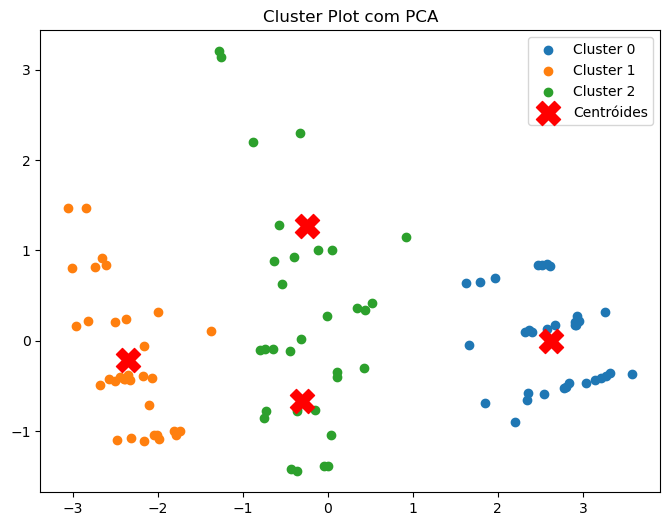

In [120]:
# Para mais de 2 dimensões usamos PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

pca_result = pca.fit_transform(df_scaled)

data['pca_1'] = pca_result[:, 0]
data['pca_2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))

for cluster_num in range(3):
    mask = data['cluster'] == cluster_num
    plt.scatter(data[mask]['pca_1'], data[mask]['pca_2'], label = f'Cluster {cluster_num}')

# Obtenha os centroides transformados para a visualização
centroids_pca = pca.transform(model_v1.cluster_centers_)
plt.scatter(centroids_pca[:, 0], 
            centroids_pca[:, 1], 
            s = 300, 
            c = 'red', 
            marker = 'X', 
            label = 'Centróides')
plt.legend()
plt.title("Cluster Plot com PCA")
plt.show()